In [1]:
import os, pickle, time
import numpy as np
import healpy as hp
from beamconv import ScanStrategy, tools
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()
%matplotlib inline

We want to test the repeatibility of our satellite scan strategy with a simple script.

In [2]:
def get_cls(fname='../ancillary/wmap7_r0p03_lensed_uK_ext.txt'):
    cls = np.loadtxt(fname, unpack=True) # Cl in uK^2
    return cls[0], cls[1:]

In [3]:
nsamp       = 1000
nside_spin  = 512
lmax        = 1000
mmax        = 1
mlen        = 10
sample_rate = 100.0
nside_out   = 256
verbose     = 1
ctime0      = 1510000000

In [4]:
# Load up alm                                                                            
ell, cls = get_cls()
np.random.seed(42)
alm = hp.synalm(cls, lmax=lmax, new=True, verbose=True) # uK  

The following two cells are not the standard way to scan the sky. The code is motivated by a want to look at some of the various scan strategy parameters to see if they resemble the pointing timelines of a satellite.

In [5]:
nsamp        = 1e6
alpha        = 50.
beta         = 50.
alpha_period = 5400.
beta_period  = 600.

sat = ScanStrategy(mlen, external_pointing=True, sample_rate=sample_rate,
    location='space', ctime0=ctime0, nside_out=nside_out)

sat.ctime0 = ctime0
sat.ctime = sat.satellite_ctime(start=0, end=nsamp)

az, el, lon, lat, qbore = sat.satellite_scan(alpha=alpha, beta=beta,
    alpha_period=alpha_period, beta_period=beta_period, return_all=True)

ra, dec, _ = sat.quat2radecpa(qbore)

time = np.arange(len(ra))/3600./sat.fsamp

print('fsamp = {}'.format(sat.fsamp))
print('nhours = {}'.format(nsamp/sat.fsamp/3600.))
print('Mean ra is = {:.8f}'.format(np.mean(ra)))             
print('Std ra is = {:.8f}'.format(np.std(ra)))             
print('Mean dec is = {:.8f}'.format(np.mean(dec)))               
print('Std dec is = {:.8f}'.format(np.std(dec)))       1        

fsamp = 100.0
nhours = 2.77777777778


Mean ra is = -6.70404608
Std ra is = 41.46116875
Mean dec is = 1.07747466
Std dec is = 40.24518601


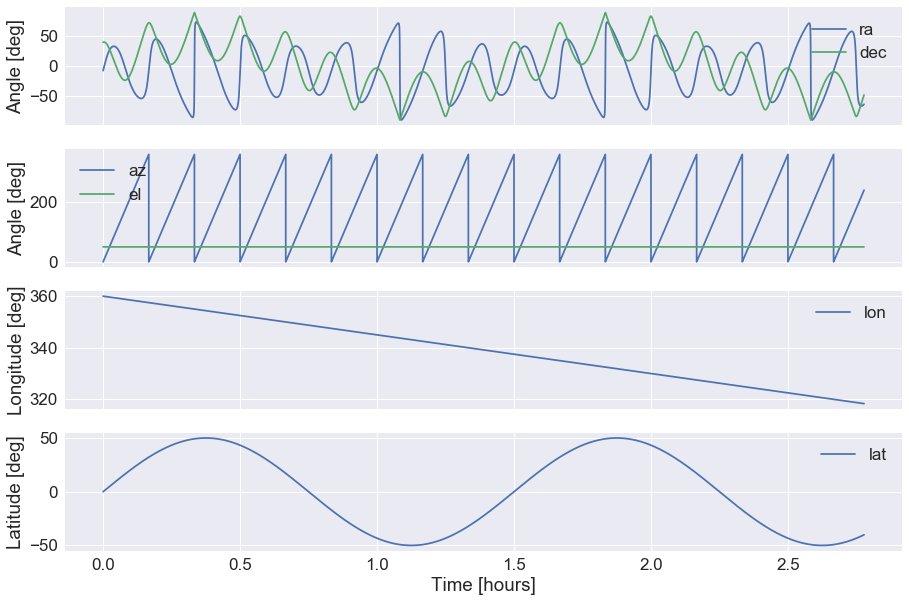

In [10]:
## Plotting up results
sns.set(font_scale=1.7)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10))
ax1.plot(time, ra, label='ra')
ax1.plot(time, dec, label='dec')
ax1.set_ylabel('Angle [deg]')
ax2.plot(time, az, label='az')
ax2.plot(time, el, label='el')
ax2.set_ylabel('Angle [deg]')
ax3.plot(time[1:], lon[1:], label='lon')
ax3.set_ylabel('Longitude [deg]')
ax4.plot(time, lat, label='lat')
ax4.set_ylabel('Latitude [deg]')
ax4.set_xlabel('Time [hours]')

for ax in [ax1, ax2, ax3, ax4]:
    ax.legend()
    
for ax in [ax1, ax2, ax3]:
    ax.xaxis.set_ticklabels([])

Scanning with 2 detectors
[rank 000]: working on: r000c000A, r000c000B
[rank 000]:	Working on chunk 000: samples 0-1000
Tod 0: -18.6217552509798274 +/- 71.4877151339593269
Scanning with 2 detectors
[rank 000]: working on: r000c000A, r000c000B
[rank 000]:	Working on chunk 000: samples 0-1000
Tod 1: -18.6217552509798274 +/- 71.4877151339593269
Scanning with 2 detectors
[rank 000]: working on: r000c000A, r000c000B
[rank 000]:	Working on chunk 000: samples 0-1000
Tod 2: -18.6217552509798274 +/- 71.4877151339593269
Scanning with 2 detectors
[rank 000]: working on: r000c000A, r000c000B
[rank 000]:	Working on chunk 000: samples 0-1000
Tod 3: -18.6217552509798274 +/- 71.4877151339593269
Scanning with 2 detectors
[rank 000]: working on: r000c000A, r000c000B
[rank 000]:	Working on chunk 000: samples 0-1000
Tod 4: -18.6217552509798274 +/- 71.4877151339593269


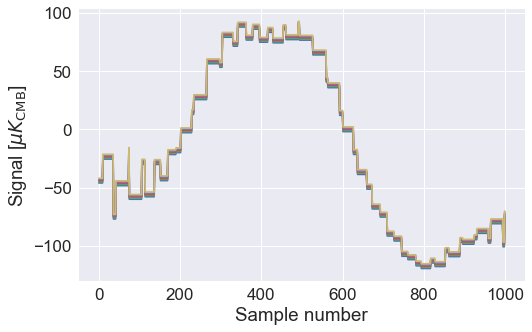

In [9]:
fig, ax1 = plt.subplots(figsize=(8, 5))
for n in range(5):
        
    sat = ScanStrategy(mlen, external_pointing=True, sample_rate=sample_rate,
        location='space', ctime0=ctime0, nside_out=nside_out)

    #ss.load_focal_plane('.', no_pairs=True)
    sat.create_focal_plane(nrow=1, ncol=1, fov=0, 
        fwhm=30., lmax=lmax, mmax=mmax, amplitude=1.,
        no_pairs=True)
    
    scan_opts = dict(q_bore_func=sat.satellite_scan,
    ctime_func=sat.satellite_ctime,
    q_bore_kwargs=dict(jitter_amp=0.),
    ctime_kwargs=dict(),
    max_spin=mmax,
    nside_spin=nside_spin)

    sat.scan_instrument_mpi(alm, verbose=verbose, binning=False, **scan_opts)
    ax1.plot(sat.tod + n)
    
    print('Tod {}: {:.16f} +/- {:.16f}'.format(n, np.mean(sat.tod), np.std(sat.tod)))
    
#ax1.legend()
ax1.set_ylabel(r'Signal [$\mu K_{\mathrm{CMB}}$]')
ax1.set_xlabel('Sample number')